In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Dropout, Conv1D, MaxPooling1D, Concatenate, SimpleRNN
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import optimizers
from keras.optimizers import *
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,CSVLogger,ModelCheckpoint

from keras_self_attention import SeqSelfAttention

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

/Users/taoli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/taoli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/taoli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/taoli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
df = pd.read_csv('./creditcard.csv')

X = df.drop('Class',axis=1)
# y = df['Class']
y_original = df['Class']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

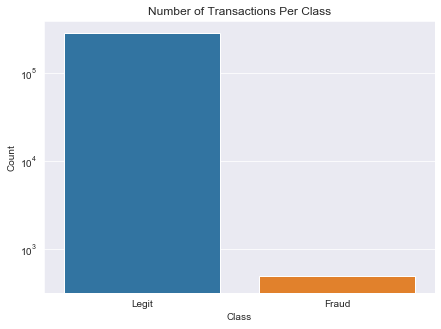

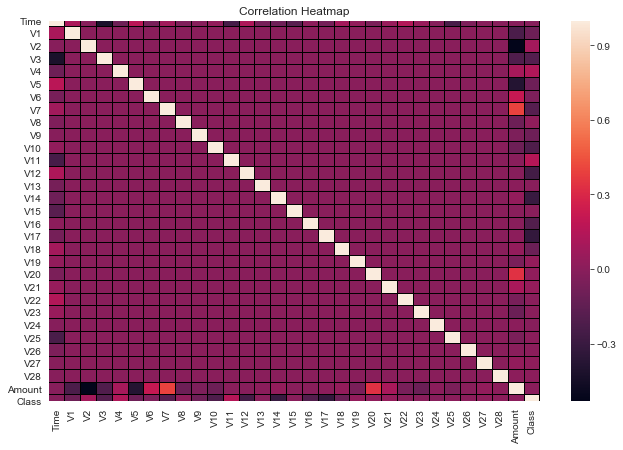

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [3]:
df.head()

df.info()

df['Class'].value_counts()

sns.set_style('darkgrid') #Set Seaborn plot style
fig, ax = plt.subplots(figsize=(7,5)) #Make the plot a little bigger.
ax.set_yscale('log') #Set the y-scale as logarithmic.
g = sns.countplot(x='Class', data=df, ax=ax) #Place the desired data on the plot.
g.set_xticklabels(['Legit','Fraud']) #Label the x-axis and y-axis correctly, and title the plot.
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Transactions Per Class')

list_of_correlations= df.corr(method='pearson')
plt.figure(figsize=(11,7))
sns.heatmap(list_of_correlations,linewidths=0.005,linecolor='k')
plt.title('Correlation Heatmap')
plt.show()

np.abs(list_of_correlations['Class']).sort_values(ascending=False).head(5)

X.head()

y_original.head()

In [4]:
rolling_window_size = 10

X_interim = np.zeros([(X.shape[0]-rolling_window_size)*rolling_window_size, 30])
y = []
for i in range((X.shape[0]-rolling_window_size)):
    beg = 0+i
    end = beg+rolling_window_size
    s = np.array(X[beg:end], dtype='float')
    X_interim[(rolling_window_size*i):(rolling_window_size*(i+1)),:] = s
    y.append(y_original[end])

In [5]:
y = np.array(y, dtype='float')
X_interim = X_interim[:,1::]
X_tensor = X_interim.reshape((int(X_interim.shape[0]/rolling_window_size)), rolling_window_size, X_interim.shape[1])

test_train_split = 0.9
stratify = True

if stratify:
    y = np.vstack((range(len(y)),y)).T
    y_pos = y[y[:,1]==1]
    y_neg = y[y[:,1]==0]
    
    y_pos = y_pos[np.random.choice(y_pos.shape[0], int(y_pos.shape[0]*test_train_split), replace=False),:]
    y_neg = y_neg[np.random.choice(y_neg.shape[0], int(y_neg.shape[0]*test_train_split), replace=False),:]
    
    train_idx = np.array(np.hstack((y_pos[:,0],y_neg[:,0])), dtype='int')
    
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx,1]
    y_test = np.delete(y, train_idx, axis=0)
    y_test = y_test[:,1]
else: 
    train_idx = np.random.choice(X_tensor.shape[0], int(X_tensor.shape[0]*test_train_split), replace=False)
    X_train = X_tensor[train_idx, :, :]
    X_test = np.delete(X_tensor, train_idx, axis=0)
    y_train = y[train_idx]
    y_test = np.delete(y, train_idx, axis=0)

del (X_tensor, y, stratify, test_train_split, train_idx, y_neg, y_pos)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(256316, 10, 29)
(256316,)
(28481, 10, 29)
(28481,)


In [6]:
# ---Resampling---

num_times = 120

X_train_fraud = X_train[y_train == 1]
y_train_fraud = y_train[y_train == 1]
X_train_normal = X_train[y_train == 0][0:X_train_fraud.shape[0]*num_times,:,:]
y_train_normal = y_train[y_train == 0][0:X_train_fraud.shape[0]*num_times]

X_train_resampled = X_train_normal
y_train_resampled = y_train_normal

for i in range(num_times):
    X_train_resampled = np.concatenate([X_train_fraud, X_train_resampled])
    y_train_resampled = np.concatenate([y_train_fraud, y_train_resampled])

print(X_train_fraud.shape)
print(X_train_normal.shape)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(442, 10, 29)
(53040, 10, 29)
(106080, 10, 29)
(106080,)


In [7]:
# Optimizer Definition/Selection

opt_adam = Adam(lr=1e-3)
opt_sgd = SGD(lr=1e-3,decay=1e-5,momentum=0.9,nesterov=True)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model = Sequential()
model.add(Conv1D(64, 5, input_shape=(X_train.shape[1], X_train.shape[2]), padding='same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, padding='same', activation = 'relu'))
model.add(Dropout(0.2))
# model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(LSTM(32, kernel_initializer='lecun_uniform', activation='relu',
               dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(32, input_shape=X_train.shape[1:], kernel_initializer='lecun_uniform', activation='relu',
#                dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid'))

# model.summary()
model.compile(optimizer = opt_adam, loss = 'binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='rmsprop',loss='binary_crossentropy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
callback = [EarlyStopping(monitor='loss',patience=10, verbose=1),
           ReduceLROnPlateau(patience=5, verbose=1),
           CSVLogger(filename='project'+'_'+'log.csv'),
           ModelCheckpoint('project_11AUG2020'+'.check',save_best_only=True,save_weights_only=True)]

# model.fit(X_train,y_train,batch_size=10000, epochs=20000, class_weight={0 : 1., 1: float(int(1/np.mean(y_train)))},
#           validation_data = (X_test,y_test),verbose = 1,callbacks=callback)
model.fit(X_train_resampled,y_train_resampled,batch_size=1024, epochs=1000,
          validation_data = (X_test,y_test),verbose = 1,callbacks=callback)

Train on 106080 samples, validate on 28481 samples
Epoch 1/1000
106080/106080 [==============================] - 26s 248us/step - loss: 1.4275 - acc: 0.5113 - val_loss: 0.6934 - val_acc: 0.5592
Epoch 2/1000
106080/106080 [==============================] - 25s 232us/step - loss: 0.7727 - acc: 0.5081 - val_loss: 0.6942 - val_acc: 0.3737
Epoch 3/1000
106080/106080 [==============================] - 25s 232us/step - loss: 0.7143 - acc: 0.5083 - val_loss: 0.7051 - val_acc: 0.1242
Epoch 4/1000
106080/106080 [==============================] - 24s 228us/step - loss: 0.6894 - acc: 0.5402 - val_loss: 0.6882 - val_acc: 0.8909
Epoch 5/1000
106080/106080 [==============================] - 24s 227us/step - loss: 0.6741 - acc: 0.5659 - val_loss: 0.6721 - val_acc: 0.9262
Epoch 6/1000
106080/106080 [==============================] - 24s 229us/step - loss: 0.6710 - acc: 0.5701 - val_loss: 0.6609 - val_acc: 0.9264
Epoch 7/1000
106080/106080 [==============================] - 24s 225us/step - loss: 0.6667

Epoch 00054: early stopping


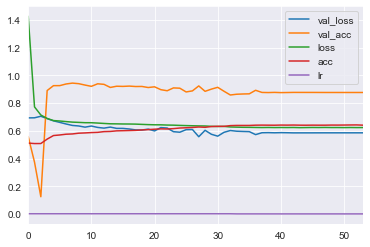

In [11]:
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.show()

In [12]:
model.load_weights('./project_11AUG2020.check')

predictions = model.predict_classes(X_test)
probs = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
#Labels for the plot
classes = ['Legit','Fraud']
predicted_classes = ['Predicted ' + item for item in classes]
actual_classes = ['Actually ' + item for item in classes]

conf_df = pd.DataFrame(data=confusion_matrix(y_test,predictions),columns=predicted_classes,
            index=actual_classes)

sns.heatmap(conf_df,annot=True,fmt='g',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks()
plt.yticks()
plt.title('Confusion matrix for the creditcard data set')
plt.show()

In [ ]:
#Plot the Precision-Recall curve and no-skill curve
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Model with No Skill')
plt.plot(recall, precision, marker='.', label='Our Neural Network Model')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Versus Recall for a Varying Threshold Parameter')

#Calculate the f1-score
fscore = (2 * precision * recall) / (precision + recall)

#Find the index of the largest f1-score and assign best threshold
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_thresh = thresholds[ix]

plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Recall/Precision corresponding to optimal f1-score')
plt.legend()
plt.show()

#Assign classes based on the best threshold
classes_on_thresh = np.array([int(p[0] > best_thresh) for p in probs])
predictions = classes_on_thresh

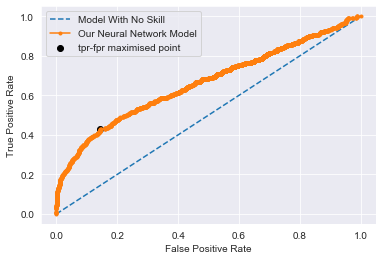

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

#Find the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

#Plot the ROC curve
plt.plot([0,1], [0,1], linestyle='--', label='Model With No Skill')
plt.plot(fpr, tpr, marker='.', label='Our Neural Network Model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='tpr-fpr maximised point')

#Label your axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#Use the optimal threshold to generate predictions
classes_on_thresh = np.array([int(p[0] > best_thresh) for p in probs])
predictions = classes_on_thresh

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train,y_train)
X_test = scaler.transform(X_test)

y_train = y_train.values
y_test = y_test.values

#Number of Legit transactions, Number of Fraud transactions
print(sum(y_train == 0), sum(y_train==1))

X_train = X_train.reshape([X_train.shape[0],X_train.shape[1],1])
X_test = X_test.reshape([X_test.shape[0],X_test.shape[1],1])

y_train = y_train.reshape([-1,y_train.shape[0]])
y_test = y_test.reshape([-1,y_test.shape[0]])

print(X_train.shape)
print(y_train.shape)

In [ ]:
model = Sequential()
model.add(Dense(units=12,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy')

In [ ]:
# ---Downsampling---

X_train, X_test, y_train, y_test = train_test_split(X, y_original, test_size=0.3, random_state=101)

#Create a dataframe which houses only the training data (so we can use pandas to manipulate it)
df_train = X_train
df_train['Class'] = y_train

df_majority = df_train[df_train['Class']==0] #Seperate the legitimate transactions
df_minority = df_train[df_train['Class']==1] #From the fraudulent transactions

#Downsample using sklearn
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=348,     
                                 random_state=101)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X = df_downsampled.drop('Class',axis=1)
y_original = df_downsampled['Class']